In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [4]:
degree = 5
n_nodes = 100
rate = 0.5
T = 100
dt = 0.01
fprefix = 'testdata/rrg_sis_'

def conversion_function(x):
    ans = [None] * len(x)
    for i in range(len(x)):
        if x[i] == 'S': ans[i] = 0.
        if x[i] == 'I': ans[i] = 1.
    return torch.tensor(ans)


In [5]:
# Generating the network
graph = nx.random_regular_graph(degree, n_nodes)
nx.write_edgelist(graph, fprefix + 'edgelist.b')

# Generating the time series
continue_simu = False
iter_max = 100
i = 0
num_sample = 10000

#if os.path.exists(fprefix + '_states.b'):
#    os.remove(fprefix + '_states.b')
data = {}
idx = 0
while(i < num_sample):
    data[idx] = []
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt, filename=None,
                                    full_data_mode=True, overwrite=True)
    t = 0
    while(t < T and sisnet.continue_simu and i < num_sample):
        t += dt
        sisnet.update(record=False)
        i += 1
        data[idx].append(sisnet.activity)
    idx += 1

f = open(fprefix + '_states.b', 'wb')
pickle.dump(data, f)
f.close()

%reset_selective -f data

In [13]:
dataset = dl.Markov_Complete_Dataset(fprefix + '_states.b', conversion_function=conversion_function)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [9999-1000, 1000])

In [14]:
n_hidden = [128,64]
n_embedding = 50
optimizer = lambda p: torch.optim.Adam(p, lr=1e-3)
use_cuda = True

markov_cvae = dl.Markov_Complete_CVAE(n_nodes, n_hidden, n_embedding, optimizer=optimizer, use_cuda=use_cuda)

In [15]:
markov_cvae.fit(train_dataset, val_dataset, epochs=100, batch_size=128)

Epoch 0 - Training Loss: 65.6188 - Validation Loss: 65.8537 - Training time: 0.9153 - New best config.
Epoch 1 - Training Loss: 48.3767 - Validation Loss: 48.7916 - Training time: 0.8619 - New best config.
Epoch 2 - Training Loss: 37.7775 - Validation Loss: 38.2793 - Training time: 0.8679 - New best config.
Epoch 3 - Training Loss: 30.8468 - Validation Loss: 31.3814 - Training time: 0.8724 - New best config.
Epoch 4 - Training Loss: 25.9883 - Validation Loss: 26.5811 - Training time: 0.8570 - New best config.
Epoch 5 - Training Loss: 22.5601 - Validation Loss: 23.1925 - Training time: 0.8674 - New best config.
Epoch 6 - Training Loss: 19.9842 - Validation Loss: 20.6306 - Training time: 0.8721 - New best config.
Epoch 7 - Training Loss: 17.9635 - Validation Loss: 18.6050 - Training time: 0.8693 - New best config.
Epoch 8 - Training Loss: 16.3456 - Validation Loss: 17.0100 - Training time: 0.8539 - New best config.
Epoch 9 - Training Loss: 15.0461 - Validation Loss: 15.7482 - Training ti

Epoch 83 - Training Loss: 5.7567 - Validation Loss: 7.5693 - Training time: 0.8596 - 
Epoch 84 - Training Loss: 5.7385 - Validation Loss: 7.5577 - Training time: 0.8729 - 
Epoch 85 - Training Loss: 5.7312 - Validation Loss: 7.5685 - Training time: 0.8757 - 
Epoch 86 - Training Loss: 5.7155 - Validation Loss: 7.5672 - Training time: 0.8830 - 
Epoch 87 - Training Loss: 5.7063 - Validation Loss: 7.5781 - Training time: 0.8709 - 
Epoch 88 - Training Loss: 5.6852 - Validation Loss: 7.5596 - Training time: 0.8565 - 
Epoch 89 - Training Loss: 5.6796 - Validation Loss: 7.5542 - Training time: 0.8813 - 
Epoch 90 - Training Loss: 5.6718 - Validation Loss: 7.5606 - Training time: 0.8593 - 
Epoch 91 - Training Loss: 5.6627 - Validation Loss: 7.5319 - Training time: 0.8769 - New best config.
Epoch 92 - Training Loss: 5.6410 - Validation Loss: 7.5453 - Training time: 0.8799 - 
Epoch 93 - Training Loss: 5.6296 - Validation Loss: 7.5177 - Training time: 0.8637 - New best config.
Epoch 94 - Training Lo

In [36]:
def test_model(learned_model, dataset):
    init_states = dataset[0][0]
    T = len(dataset)
    t = 0
    learned_states, z, passed_states = learned_model.predict(init_states)
    learned_avg = [np.mean(learned_states)]
    while(t < T):
        t += 1
        
        learned_states, z, passed_states = learned_model.predict(passed_states)
        learned_states = torch.bernoulli(torch.tensor(learned_states[0]))
        passed_states = learned_states
        learned_avg.append(np.mean(learned_states.numpy()))
    
    return learned_avg

def show_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg


In [41]:
null_cvae = dl.Markov_Complete_CVAE(n_nodes, n_hidden, n_embedding, optimizer=optimizer, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
null_ts = test_model(null_cvae, dataset)
trained_ts = test_model(markov_cvae, dataset)


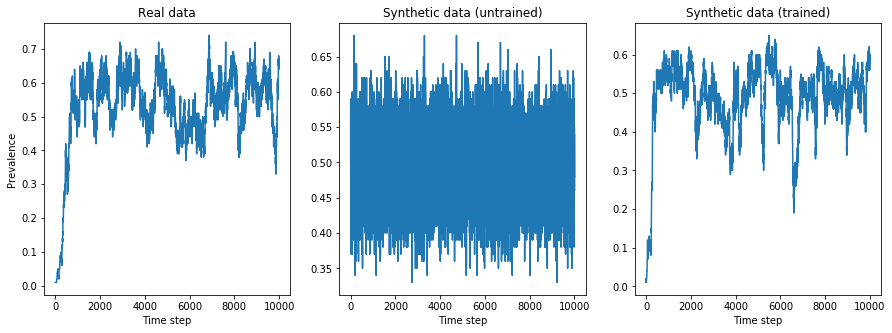

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(null_ts)
ax[1].set_title('Synthetic data (untrained)')
ax[1].set_xlabel('Time step')

ax[2].plot(trained_ts)
ax[2].set_title('Synthetic data (trained)')
ax[2].set_xlabel('Time step')

fig.savefig('fig/png/test_rrgsis_d5_n100_rate0.4.png')
fig.savefig('fig/pdf/test_rrgsis_d5_n100_rate0.4.pdf')
plt.show()